In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

# Define the extraction path, including a subfolder
extraction_path = '/content/drive/MyDrive/DL_miniproject'  # Or any other subfolder within your Drive

#ith zipfile.ZipFile('/content/Images.zip', 'r') as zip_ref:
    #zip_ref.extractall(extraction_path)  # Extract to the specified path

 Import Necessary Libraries

In [ ]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

Extract Features from Images using VGG16

In [ ]:
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(extraction_path, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):

    #image resizing
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to a numpy array
    image = img_to_array(image)

    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    #Normalization
    image = preprocess_input(image)

    # Extract features
    image_feature = model.predict(image, verbose=0)

    # Get the image ID
    image_id = img_name.split('.')[0]

    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8090 [00:00<?, ?it/s]

In [ ]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(extraction_path, 'img_features.pkl'), 'wb'))

In [ ]:
# Load features from pickle file
pickle_file_path = os.path.join(extraction_path, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

Load Captions

In [ ]:
with open(os.path.join(extraction_path, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):

    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens

    # Remove extension from image ID
    image_id = image_id.split('.')[0]

    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


# Preprocessing Captions

In [ ]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]

            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [ ]:
# preprocess the text
clean(image_to_captions_mapping)

In [ ]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [ ]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [ ]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [ ]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


In [ ]:
def build_image_caption_model(vocab_size, max_caption_length):
    # Image features input
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe2_projected = RepeatVector(max_caption_length)(fe2)
    fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

    # Caption input
    inputs2 = Input(shape=(max_caption_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

    # Attention mechanism
    attention = Dot(axes=[2, 2])([fe2_projected, se3])
    attention_scores = Activation('softmax')(attention)
    attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

    # Decoder
    decoder_input = concatenate([context_vector, fe2], axis=-1)
    decoder1 = Dense(256, activation='relu')(decoder_input)
    outputs = Dense(vocab_size, activation='softmax')(decoder1)

    # Final model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model


# Train Test Split

In [ ]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys:
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

#Define the Data Generator

In [ ]:


def data_generator(data, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        X_image, X_seq, y = [], [], []

        for img_id in data:
            captions = image_to_captions_mapping[img_id]
            feature_vector = loaded_features[img_id]

            for caption in captions:
                # Convert caption to sequence
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # One-hot encode output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to batch
                    X_image.append(feature_vector)  # Image features
                    X_seq.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

                    # Batch check
                    if len(X_image) == batch_size:
                        yield (tf.convert_to_tensor(np.squeeze(np.array(X_image)), dtype=tf.float32),
                               tf.convert_to_tensor(np.array(X_seq), dtype=tf.float32)), \
                              tf.convert_to_tensor(np.array(y), dtype=tf.float32)
                        X_image, X_seq, y = [], [], []



#Define the CNN-BiLSTM + Attention  and training model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, RepeatVector, Activation, Lambda, Dot, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from math import ceil

# Define constants
max_caption_length = 20  # Example max caption length
vocab_size = 8768  # Example vocabulary size
batch_size = 32  # Training batch size
epochs = 100  # Number of training epochs

# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers (Processing captions)
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Compute attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis using a Lambda layer
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


# Ensure train and test datasets are loaded before proceeding
if 'train' not in locals() or 'test' not in locals():
    raise ValueError("Dataset variables 'train' and 'test' are not defined.")

# Compute training & validation steps
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

from tensorflow.keras.preprocessing.sequence import pad_sequences



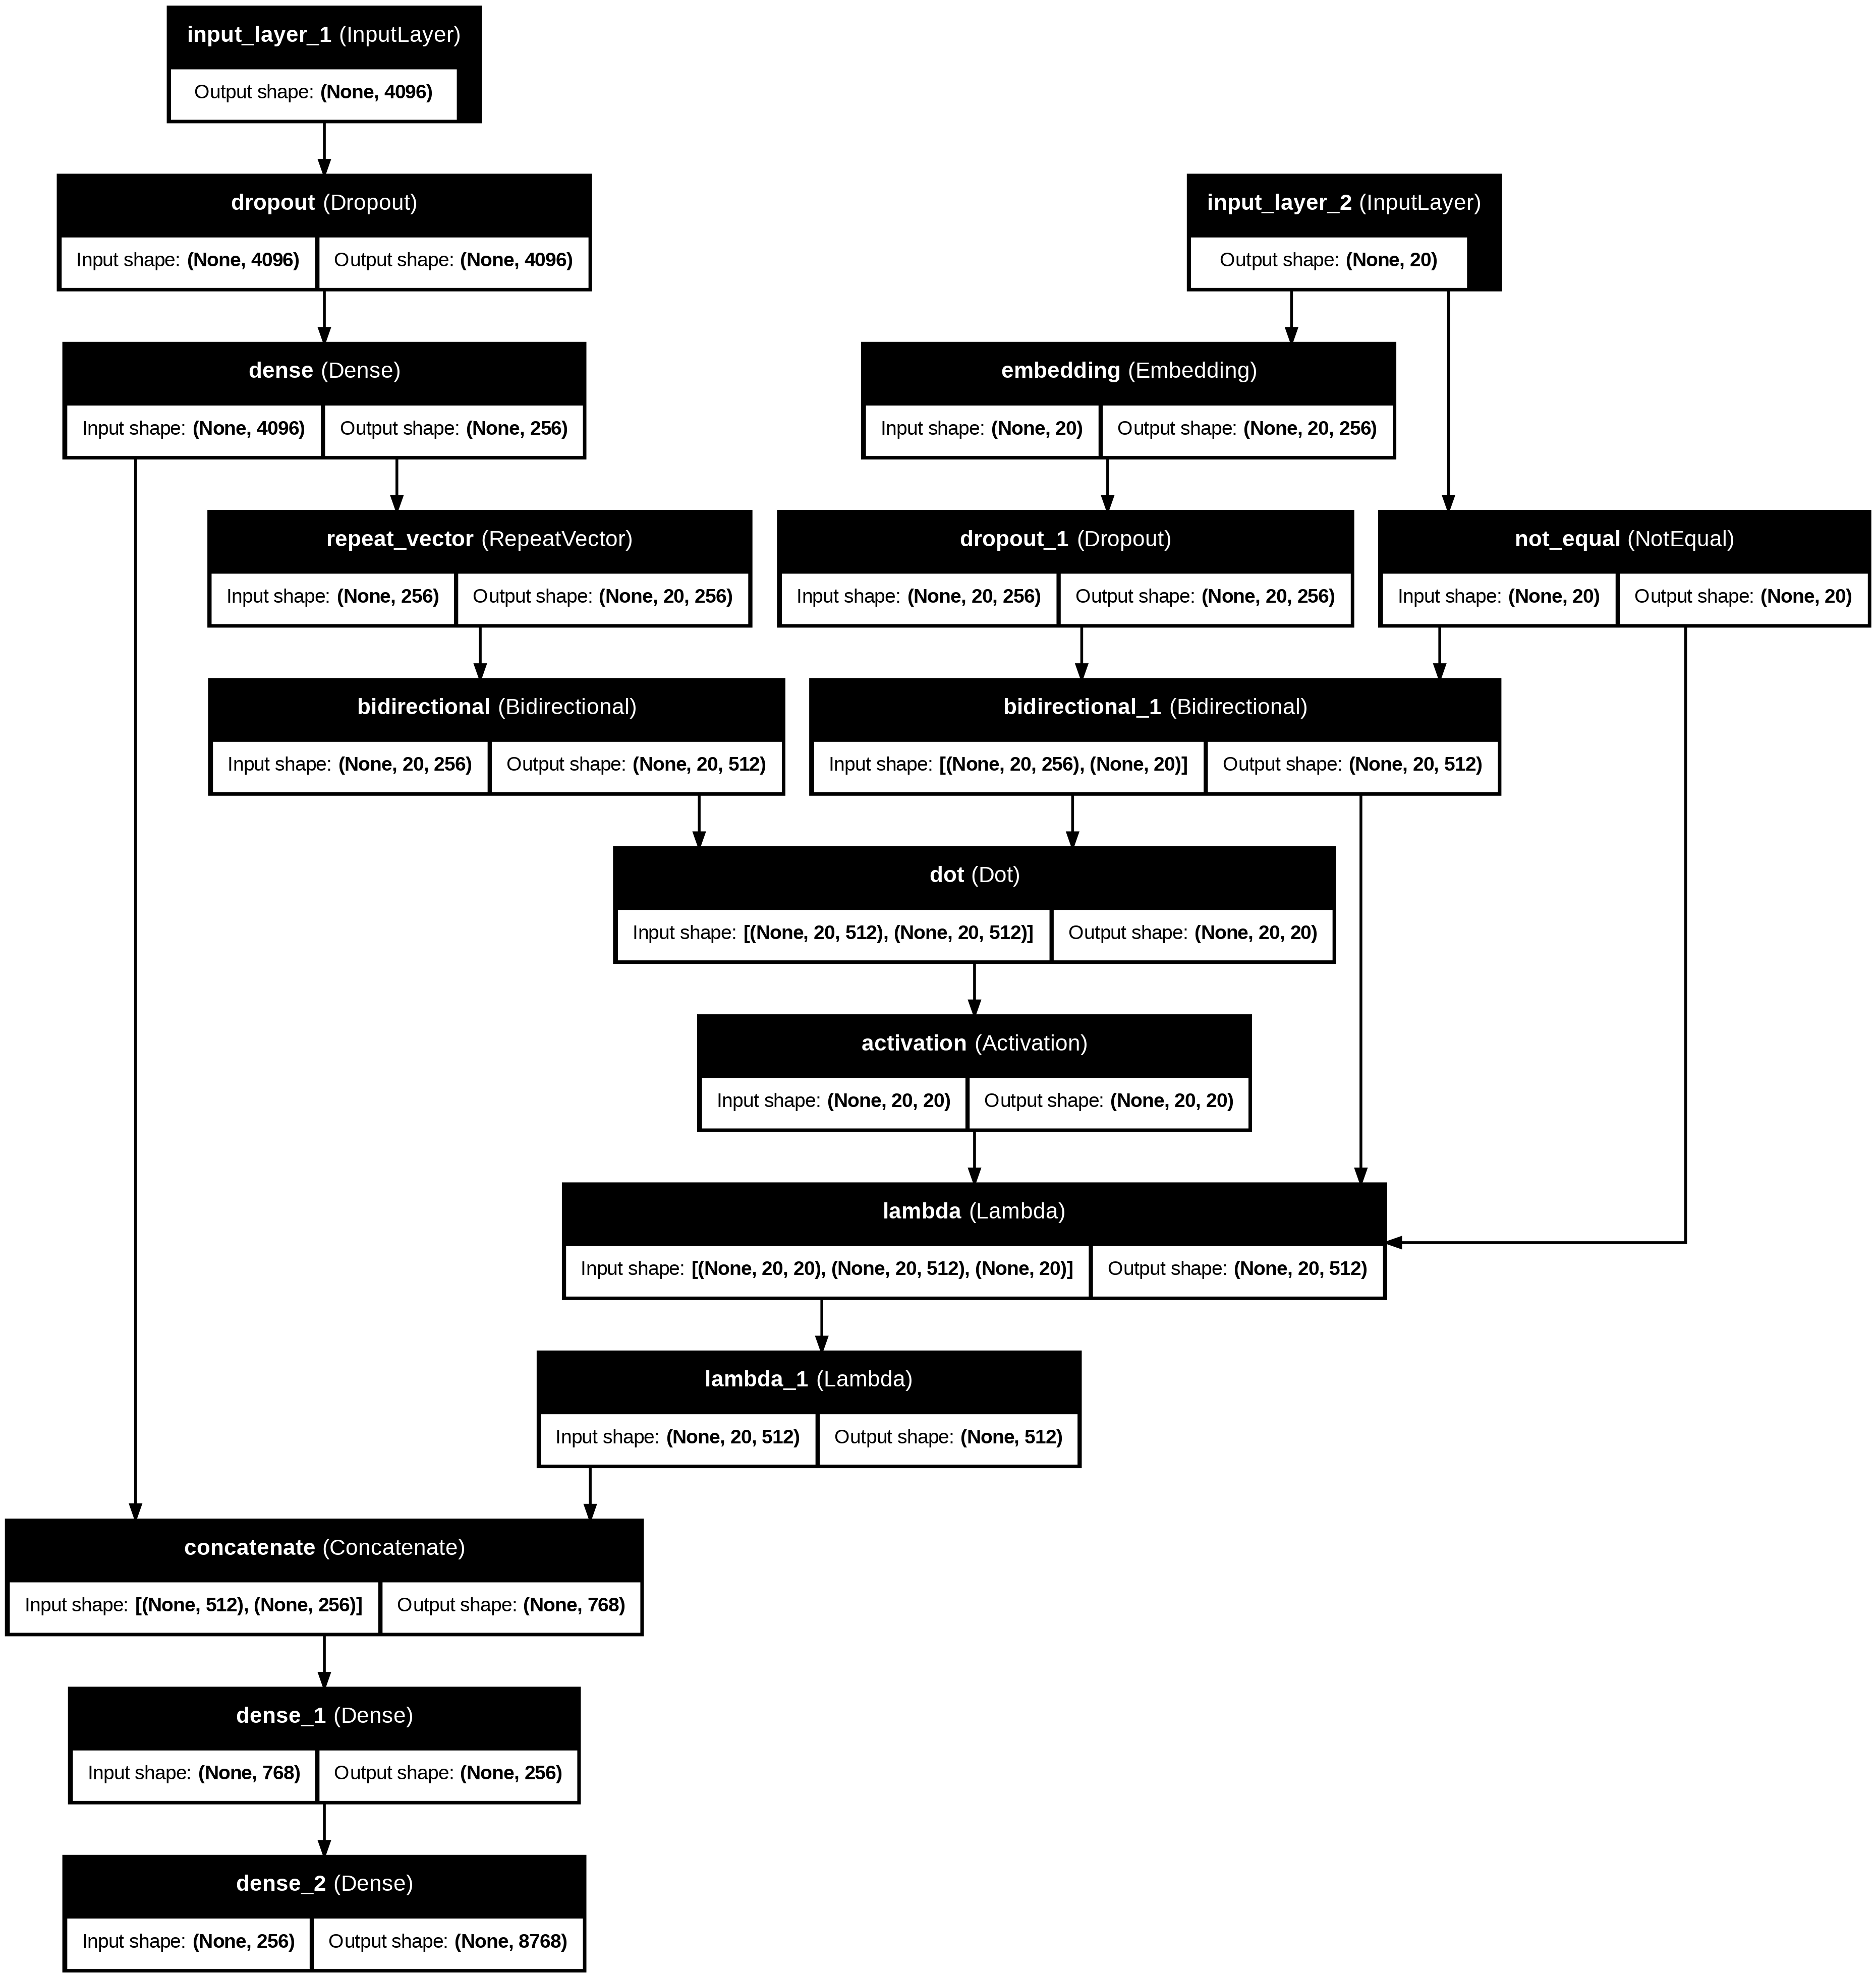

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

def data_generator(data, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        X_image, X_seq, y = [], [], []

        for img_id in data:
            captions = image_to_captions_mapping[img_id]
            feature_vector = loaded_features[img_id]

            for caption in captions:
                # Convert caption to sequence
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad input sequence with right padding (padding='post')
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]

                    # One-hot encode output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append to batch
                    X_image.append(feature_vector)  # Image features
                    X_seq.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

                    # Batch check
                    if len(X_image) == batch_size:
                        yield (tf.convert_to_tensor(np.squeeze(np.array(X_image)), dtype=tf.float32),
                               tf.convert_to_tensor(np.array(X_seq), dtype=tf.float32)), \
                              tf.convert_to_tensor(np.array(y), dtype=tf.float32)
                        X_image, X_seq, y = [], [], []



# Remove mask_zero=True from the Embedding layer in your model definition:
se1 = Embedding(vocab_size, 256)(inputs2)  # Removed mask_zero=True


Train the Model

In [ ]:
# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


# Ensure train and test datasets are loaded before proceeding
if 'train' not in locals() or 'test' not in locals():
    raise ValueError("Dataset variables 'train' and 'test' are not defined.")

# Compute training & validation steps
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

from tensorflow.keras.preprocessing.sequence import pad_sequences
# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    # Train for one epoch
    model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator,
        validation_steps=validation_steps,
        verbose=1
    )


Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 6.7932 - val_loss: 6.3870

Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 5.2140 - val_loss: 6.4345

Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.7995 - val_loss: 6.6156

Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 4.5086 - val_loss: 6.2615

Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.1029 - val_loss: 6.2870

Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.8572 - val_loss: 6.4820

Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.5553 - val_loss: 6.6804

Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.3061 - val_loss: 6.8311

Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3.1006 - val_loss: 7.5180

Epoch 10/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2.8389 - val_loss: 7.2510

Epoch 11/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.6449 - val_loss: 7.5317

Epoch 12/100
228/

In [ ]:
# Save the model
model.save(os.path.join(extraction_path, 'mymodel.h5'))

#Caption Prediction

In [ ]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [ ]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'

    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        # Explicitly specify padding='post' to ensure right padding
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word to the caption
        caption += " " + predicted_word

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break  # Indented to be part of the 'if' block

    return caption

 # BLEU Score Evaluation

In [ ]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.422882
BLEU-2: 0.177651


# Predicting captions for testing Images

In [ ]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    # Corrected path: Removed the extra 'Images' from the path
    img_path = os.path.join('/content/drive/MyDrive/DL_miniproject/Images', image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man skis past another man displaying paintings in the snow endseq


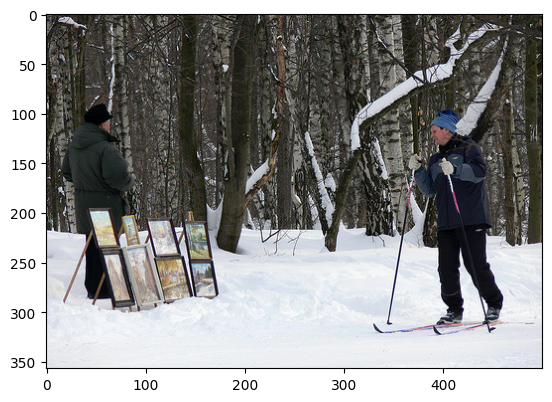

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy sliding down slide into pool with colorful tubes endseq


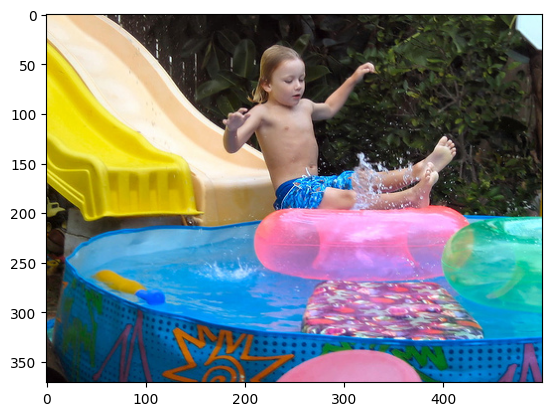

In [ ]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq


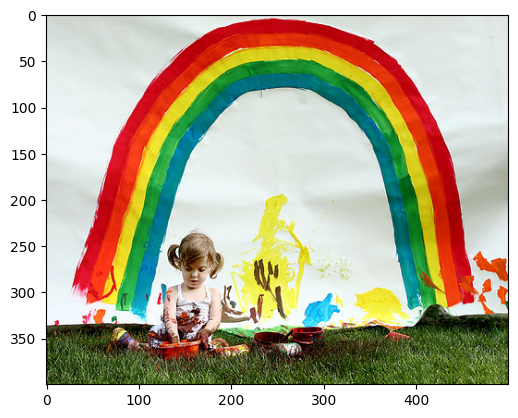

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man stands in front of very tall building endseq


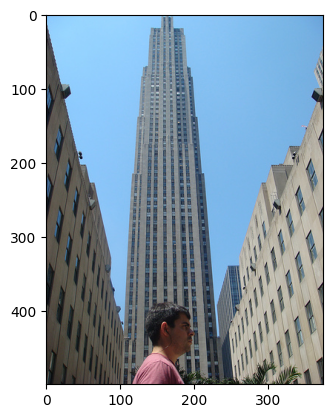

In [ ]:
generate_caption("1032460886_4a598ed535.jpg")